In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shelve
import numba as nb

In [2]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,beta,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,beta,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,beta,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,beta,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,beta,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,beta,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i]-beta)/N + K*R1*np.cos(x[i]-beta)/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F, beta= p[0],p[1], p[2],p[3]
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]     
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,beta,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F, beta = p[0],p[1], p[2],p[3]
    X = np.empty((N,runlen),dtype='float64')
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,beta,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def nb_dot( x, y): 
    res = np.zeros(1,dtype = 'float64')
    for i in nb.prange(x.shape[0]):
        res+=x[i]*y[i]
    return res

@nb.njit()
def nb_concatdot30( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1]
            res[1]+=x[1,i]*y[i-1]
            res[2]+=x[2,i]*y[i-1]
    return res

@nb.njit()
def NMSE(yeval,ydata):
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def varRK4(t, state, dt, f, p, pvec,Wout,w,N):
    tmid = t + dt*0.5
    k1 = dt*fkura_closed(t,state,p,pvec,Wout,w,N) 
    k2 = dt*fkura_closed(t,state + 0.5 * k1,p,pvec,Wout,w,N)
    k3 = dt*fkura_closed(t,state + 0.5 * k2,p,pvec,Wout,w,N) 
    k4 = dt*fkura_closed(t + dt ,state + k3,p,pvec,Wout,w,N)
    y= (state + (1.0/6.0) * (k1 + 2*k2 + 2*k3 + k4))
    return ( y % (2*math.pi))
    
@nb.njit()
def fkura_closed(t,x,p,pvec,Wout,w,N):
    uin, K,F,beta = p[0],p[1],p[2],p[3]
    one_hot = pvec
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i]-beta)/N + K*R1*np.cos(x[i]-beta)/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i]) 
    return y

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 

@nb.njit()
def solve(N,testlen, x0, p,pvec, Wout,u0, w , dt):
    X = np.zeros((N,testlen+1), dtype = 'float64') 
    U_pred = np.zeros((3,testlen+1), dtype = 'float64')
    U_pred[:,0] = u0
    Up=u0
    X[:,0] = x0
    t=0
    for i in range(0,testlen):
        t=dt+t
        X[:,i+1] = varRK4(t, X[:,i], dt, fkura_closed, p, pvec,Wout,w,N)
        xstate = concat_nb0(np.sin(X[:,i+1]), np.sin(X[:,i+1])**2)
        Up= nb_concatdot30(Wout, xstate)
        U_pred[:,i+1]= Up  
    return  U_pred[:,1:]

In [3]:
with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['kuramoto-sakaguchi']   

In [4]:
N=p_dict['N'] 
w=p_dict['w']
K,F,beta, uin= p_dict['K'],p_dict['F'],p_dict['beta'], p_dict['uin']
one_hot_output = p_dict['one_hot']
h= p_dict['h']
reg = p_dict['reg']

initlen = p_dict['initlen']
trainlen = p_dict['trainlen']
testlen = p_dict['testlen']*30 

data_scaled= (data)/(30)
ut0 =np.eye(3)[one_hot_output] @ data_scaled[:,::20]
utmid =np.eye(3)[one_hot_output] @ data_scaled[:,10:][:,::20]
ut1 =np.eye(3)[one_hot_output] @  data_scaled[:,20:][:,::20]

p = np.array([uin, K,F,beta])

In [5]:
x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)
Yt = data_scaled [:,::20][:,(initlen+1):(initlen+trainlen+1)].T
Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
pred = (Wout @ X)

nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

u0 = Yt.T[:,-1]
x0= X0[:,-1] 

ydata = data_scaled[:,::20][:, initlen+trainlen+1:initlen+trainlen+testlen+1]

U_pred = solve(N,testlen, x0, p,one_hot_output, Wout,u0, w ,h)
nmse_test = NMSE(U_pred,ydata)

nmse_test_mean  = np.round(nmse_test.mean(),4)

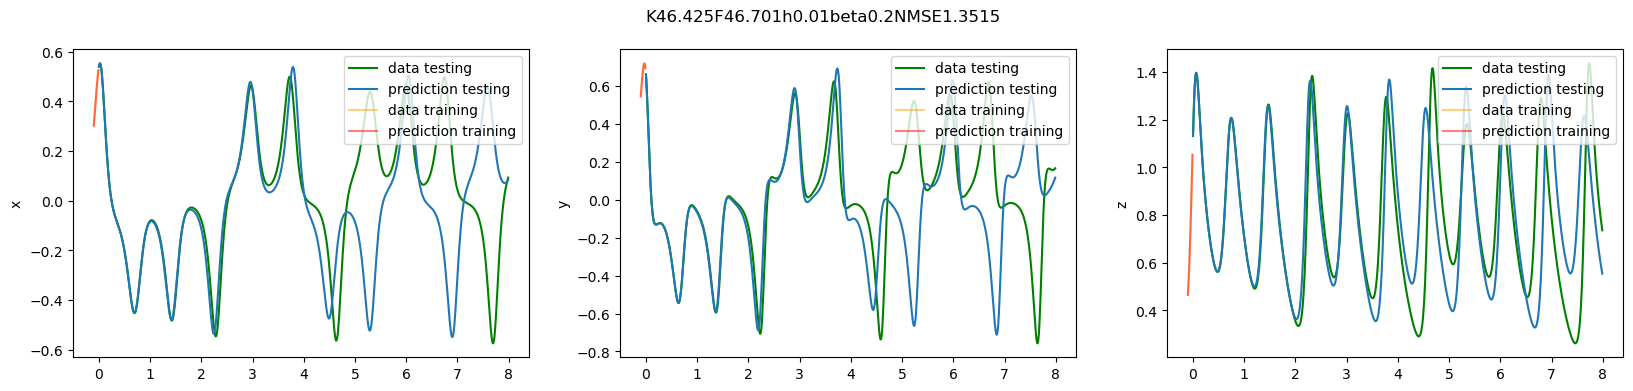

In [6]:
#short time time series

fig, ax = plt.subplots(1, 3,figsize=(20,4))
fig.suptitle(f'K{K}F{F}h{h}beta{beta}NMSE{np.round(nmse_test_mean,4)}')
ylist=['x','y','z']
plotlen=800
for i in range(0,3):
    ax[i].plot(np.arange(0,plotlen,1)*0.01, data_scaled[:,::20][i, initlen+trainlen+1:initlen+trainlen+1+plotlen],c='green',label = 'data testing')
    ax[i].plot(np.arange(0,plotlen,1)*0.01, U_pred[i,:plotlen],label='prediction testing',c='C0')
    ax[i].plot(np.arange(-10,0)*0.01, Yt.T[i,-10:],alpha=0.5,color = 'orange', label='data training')
    ax[i].plot(np.arange(-10,0)*0.01, pred[i,-10:],alpha=0.5, color='red', label='prediction training')
    ax[i].legend(loc='upper right')
    ax[i].set_ylabel(ylist[i])

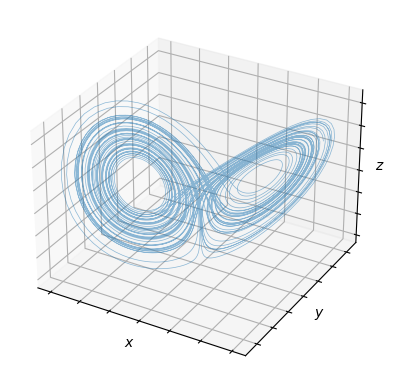

In [8]:
# long-time attractor

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*U_pred, lw=0.5,alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10